In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import pandas as pd
import matplotlib.pyplot as plt

/cvmfs/software.igwn.org/conda/envs/igwn-py310/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
frg_r_all = pd.read_csv("../SN2024jlf/SN2024jlf_frg_r.csv")
frg_r_all

,Unnamed: 0,MJD,filter,unforced_mag,unforced_mag_error,unforced_mag_status,forced_ujy,forced_ujy_error
0,0,60530.217789,r,15.545,0.031,positive,NaN,NaN
1,4,60524.224201,r,15.413,0.041,positive,2563.0,11.6
2,5,60520.214849,r,15.389,0.026,positive,2706.6,10.7
3,8,60515.266620,r,15.363,0.028,positive,2729.7,14.7
4,10,60513.256863,r,15.361,0.028,positive,2706.4,14.1
5,12,60511.277639,r,15.348,0.027,positive,2729.4,19.2
6,14,60504.235567,r,15.315,0.031,positive,2961.4,12.8
7,15,60502.242616,r,15.274,0.037,positive,3094.8,12.2
8,16,60494.233854,r,15.262,0.034,positive,2991.3,10.6
9,18,60490.269016,r,15.246,0.035,positive,2942.8,10.7


In [3]:
def plot_fig(X,y,X_test,y_pred,sigma):
    plt.close()
    plt.figure(figsize=(10, 6))
    plt.plot(X, y, 'ro', label="Observed Data")  # Original data points
    plt.plot(X_test, y_pred, 'b-', label="GPR Prediction")  # Mean prediction
    plt.fill_between(X_test.ravel(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, color='blue', alpha=0.2, label="95% Confidence Interval")
    plt.xlabel("MJD")
    plt.ylabel("Unforced Magnitude")
    plt.gca().invert_yaxis()
    plt.title("Gaussian Process Regression for MJD vs Unforced Magnitude")
    plt.legend()
    plt.show()
    return()

In [4]:
def GPR(X,y,plot):
    # Define kernel (e.g., Constant Kernel * RBF Kernel
    kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
    # Initialize Gaussian Process Regressor
    gpr = GaussianProcessRegressor(kernel=kernel, random_state=42)
    # Fit to the data
    gpr.fit(X, y)
    
    # Predict with uncertainty
    X_test = np.linspace(X.min(), X.max(), 1000).reshape(-1, 1) 
    y_pred, sigma = gpr.predict(X_test, return_std=True)
    
    idx = np.argmax(y_pred)
    t_sbo = X_test[idx].item()
    print ("Shock break out time = ", t_sbo)
    
    
    if plot:
        plot_fig(X,y,X_test,y_pred,sigma)

    return (t_sbo)

In [6]:
N_loop = 5
N_remove = 5

t_sbo = []
i = 1

while i <= N_loop:
    print(i)
    frg_r = frg_r_all.sample(n=len(frg_r_all) - N_remove).reset_index(drop=True)
    X = frg_r[['MJD']].values
    y = frg_r[['unforced_mag']].values
    t = GPR(X,y,False)
    t_sbo.append(t)
    
    i += 1

1
Shock break out time =  60530.217789
2
Shock break out time =  60466.449296720726
3
Shock break out time =  60458.338391
4
Shock break out time =  60459.39134373874
5
Shock break out time =  60529.11973512613


In [7]:
mean_t = np.mean(t_sbo)
print (mean_t)

# Calculate relative errors: (value - mean) / mean
relative_errors = (t_sbo - mean_t) / mean_t
print (relative_errors)

60488.70331111712
[ 0.00068632 -0.0003679  -0.00050199 -0.00048459  0.00066816]


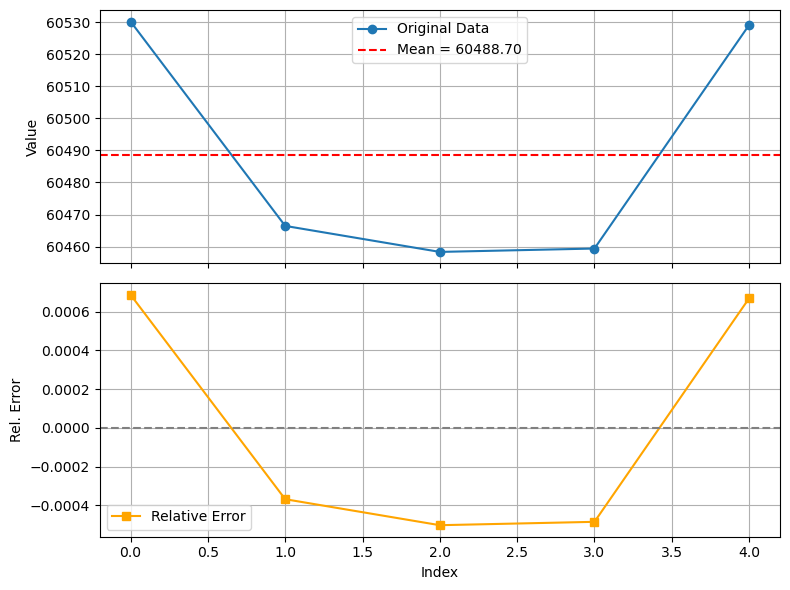

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Plot original data with mean
axs[0].plot(t_sbo, marker='o', label='Original Data')
axs[0].axhline(mean_t, color='red', linestyle='--', label=f'Mean = {mean_t:.2f}')
axs[0].set_ylabel('Value')
axs[0].legend()
axs[0].grid(True)

# Plot relative error
axs[1].plot(relative_errors, marker='s', color='orange', label='Relative Error')
axs[1].axhline(0, color='gray', linestyle='--')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Rel. Error')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()